# Homework: Implementing Deep Neural Networks in TensorFlow


### Goals:
- Introduce the basics of `TensorFlow`
- Implement the digit classifier using the low level `TensorFlow` API
- Test Deep Neural Networks on real datasets and benchmark the results

# Introduction to TensorFlow

TensorFlow is a dynamic graph computation engine, that allows automatic differentiation of each node. Tensorflow is the default computational backend of the Keras library. It can also be used directly from Python to build deep learning models.

- https://www.tensorflow.org
- https://www.tensorflow.org/tutorials/quickstart/advanced

TensorFlow builds where nodes may be:
- **constant:** constants tensors, such as training data;
- **Variables:** any tensor that is meant to be updated when training, such as parameters of the models.


In [ ]:
#pip install tensorflow

In [ ]:
import tensorflow as tf
a = tf.constant(3)
a

<tf.Tensor: shape=(), dtype=int32, numpy=3>

In [ ]:
c = tf.Variable(0)
b = tf.constant(2)
c = a + b

c

<tf.Tensor: shape=(), dtype=int32, numpy=5>

In [ ]:
A = tf.constant([[0, 1], [2, 3]], dtype=tf.float32)
A

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0., 1.],
       [2., 3.]], dtype=float32)>

A tf.Tensor can be converted to numpy the following way:

In [ ]:
A.numpy()

array([[0., 1.],
       [2., 3.]], dtype=float32)

In [ ]:
b = tf.Variable([1, 2], dtype=tf.float32)
b

<tf.Variable 'Variable:0' shape=(2,) dtype=float32, numpy=array([1., 2.], dtype=float32)>

In [ ]:
tf.reshape(b, (-1, 1))

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[1.],
       [2.]], dtype=float32)>

In [ ]:
tf.matmul(A, tf.reshape(b, (-1, 1)))

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[2.],
       [8.]], dtype=float32)>

### Exercise

Write a function that computes the squared Euclidean norm of an 1D tensorf input x:

- Use element wise arithmetic operations (`+`, `-`, `*`,  `/`, `**`)
- Use `tf.reduce_sum` to compute the sum of the element of a Tensor.

In [ ]:
x = tf.Variable([1, -4], dtype=tf.float32)
x

<tf.Variable 'Variable:0' shape=(2,) dtype=float32, numpy=array([ 1., -4.], dtype=float32)>

In [ ]:
def squared_norm(x):
    return tf.reduce_sum(x ** 2)

In [ ]:
# %load solutions/tf_squared_norm.py

In [ ]:
squared_norm(x)

<tf.Tensor: shape=(), dtype=float32, numpy=17.0>

In [ ]:
squared_norm(x).numpy()

17.0

### Autodiff and Gradient Descent

In [ ]:
x = tf.Variable([1, -4], dtype=tf.float32)


with tf.GradientTape() as tape:
    result = squared_norm(x)
    #tf.GradientTape for automatic differentiation;
    # computing the gradient of a computation with respect to some inputs


variables = [x]
gradients = tape.gradient(result, variables)
gradients

[<tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 2., -8.], dtype=float32)>]

In [ ]:
grad_x = gradients[0]

In [ ]:
x


<tf.Variable 'Variable:0' shape=(2,) dtype=float32, numpy=array([ 1., -4.], dtype=float32)>

We can apply a gradient step to modify x in place by taking one step of gradient descent:

In [ ]:
x.assign_sub(0.1 * grad_x)
x.numpy()

array([ 0.8, -3.2], dtype=float32)

Execute the following gradient descent step many times consecutively to watch the decrease of the objective function and the values of `x` converging to the minimum of the `squared_norm` function.

Hit `[ctrl]-[enter]` several times to execute the same Jupyter notebook cell over and over again.

In [ ]:
with tf.GradientTape() as tape:
    objective = squared_norm(x)

x.assign_sub(0.1 * tape.gradient(objective, [x])[0])

print(f"objective = {objective.numpy():e}")
print(f"x = {x.numpy()}")

objective = 1.088000e+01
x = [ 0.64 -2.56]


### Device-aware Memory Allocation

To explicitely place tensors on a device, use context managers:

In [ ]:
with tf.device("CPU:0"):
    x_cpu = tf.constant(3)

# with tf.device("GPU:0"):
#     x_gpu = tf.constant(3)
x_cpu.device

'/job:localhost/replica:0/task:0/device:CPU:0'

## Building a Digits Classifier in TensorFlow

### Dataset:
- http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html#sklearn.datasets.load_digits

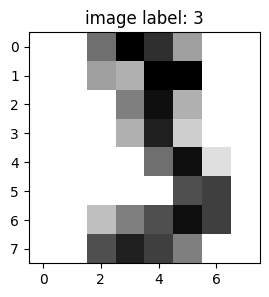

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits

digits = load_digits()

sample_index = 45
plt.figure(figsize=(3, 3))
plt.imshow(digits.images[sample_index], cmap=plt.cm.gray_r,
           interpolation='nearest')
plt.title("image label: %d" % digits.target[sample_index]);

### Preprocessing

- Normalization
- Train / test split

In [ ]:
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

data = np.asarray(digits.data, dtype='float32')
target = np.asarray(digits.target, dtype='int32')

X_train, X_test, y_train, y_test = train_test_split(
    data, target, test_size=0.15, random_state=37)

# mean = 0 ; standard deviation = 1.0
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# print(scaler.mean_)
# print(scaler.scale_)
(X_train.shape, y_train.shape), (X_test.shape, y_test.shape)

(((1527, 64), (1527,)), ((270, 64), (270,)))

TensorFlow provides dataset abstraction which makes it is to iterate over the data batch by batch:

In [ ]:
def gen_dataset(x, y, batch_size=128):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=10000, seed=42)
    dataset = dataset.batch(batch_size=batch_size)
    return dataset

In [ ]:
dataset = gen_dataset(X_train, y_train)
dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 64), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
batch_x, batch_y = next(iter(dataset))
batch_x.shape

TensorShape([128, 64])

In [ ]:
 batch_y.shape

TensorShape([128])

### Build a model using TensorFlow

- Using TensorFlow, build a similar model (one hidden layer) as you previously did;
- The input will be a batch coming from X_train, and the output will be a batch of ints;
- The output do not need be normalized as probabilities, the softmax will be moved to the loss function.

In [ ]:
# helper functions to use to test your randomly initialized model:

def init_weights(shape):
    return tf.Variable(tf.random.normal(shape, stddev=0.01))


def accuracy(y_pred, y):
    return np.mean(np.argmax(y_pred, axis=1) == y)


def test_model(model, x, y):
    dataset = gen_dataset(x, y)
    preds, targets = [], []

    for batch_x, batch_y in dataset:
        preds.append(model(batch_x).numpy())
        targets.append(batch_y.numpy())

    preds, targets = np.concatenate(preds), np.concatenate(targets)
    return accuracy(preds, targets)

Define your model there, and then execute the following cell to train your model.
Don't hesitate to tweak the hyperparameters.

In [ ]:
# hyperparams
batch_size = 32
hid_size = 15
learning_rate = 0.5
num_epochs = 10
input_size = X_train.shape[1]
output_size = 10


# build the model and weights
class MyModel:
    def __init__(self, input_size, hid_size, output_size):
        # randomly initialize all the internal variables of the model:
        self.W_h = init_weights([input_size, hid_size])
        self.b_h = init_weights([hid_size])
        self.W_o = init_weights([hid_size, output_size])
        self.b_o = init_weights([output_size])

    def __call__(self, inputs):
        # this method should implement the forward pass with
        # tensorflow operations: compute the outputs, that is the
        # unnormalized predictions of the network for a give batch
        # of inputs vectors.
        # No need to implement the softmax operations as we will
        # move it the loss function instead.

        # Hint: you can use tf.matmul, tf.tanh, tf.sigmoid,
        # arithmetic operations and so on.
        h = tf.nn.sigmoid(tf.matmul(inputs, self.W_h) + self.b_h)
        return tf.matmul(h, self.W_o) + self.b_o

model = MyModel(input_size, hid_size, output_size)

In [ ]:
# %load solutions/tf_model.py
logits = model(X_test[:1])
logits.numpy()

array([[ 0.00737174, -0.00769683, -0.00192661, -0.0135047 ,  0.01407218,
         0.0494116 ,  0.02454551, -0.01039417, -0.00279989, -0.00879737]],
      dtype=float32)

In [ ]:
y_test[:1]

array([2], dtype=int32)

In [ ]:
test_model(model, X_test, y_test)

0.11481481481481481

The following implements a training loop in Python. Note the use of `tf.GradientTape` to automatically compute the gradients of the loss w.r.t. the different parameters of the model:

Epoch 0, train_acc = 0.4977, test_acc = 0.4593
Epoch 1, train_acc = 0.8003, test_acc = 0.7556
Epoch 2, train_acc = 0.8841, test_acc = 0.8815
Epoch 3, train_acc = 0.9384, test_acc = 0.937
Epoch 4, train_acc = 0.9555, test_acc = 0.9519
Epoch 5, train_acc = 0.9679, test_acc = 0.9481
Epoch 6, train_acc = 0.9745, test_acc = 0.9519
Epoch 7, train_acc = 0.9777, test_acc = 0.9593
Epoch 8, train_acc = 0.9823, test_acc = 0.9593
Epoch 9, train_acc = 0.9836, test_acc = 0.9593


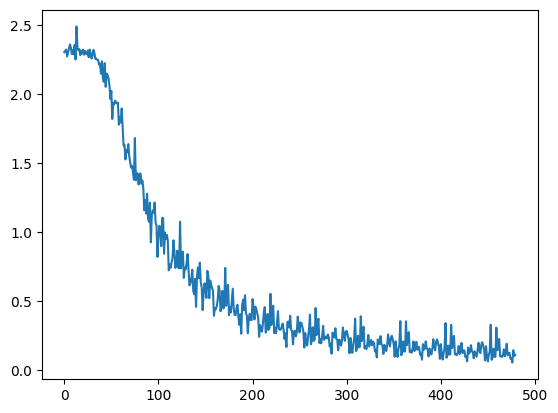

In [ ]:
losses = []
for e in range(num_epochs):
    train_dataset = gen_dataset(X_train, y_train, batch_size=batch_size)

    for batch_x, batch_y in train_dataset:
        # tf.GradientTape records the activation to compute the gradients:
        with tf.GradientTape() as tape:
            logits = model(batch_x)
            loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(batch_y, logits))
            losses.append(loss.numpy())

        # Here we ask for the gradients of dL/dW_h, etc.
        dW_h, db_h, dW_o, db_o = tape.gradient(
            loss, [model.W_h, model.b_h, model.W_o, model.b_o])

        # Update the weights as a Stochastic Gradient Descent would do:
        model.W_h.assign_sub(learning_rate * dW_h)
        model.b_h.assign_sub(learning_rate * db_h)
        model.W_o.assign_sub(learning_rate * dW_o)
        model.b_o.assign_sub(learning_rate * db_o)

    train_acc = test_model(model, X_train, y_train)
    test_acc = test_model(model, X_test, y_test)
    print("Epoch {}, train_acc = {}, test_acc = {}".format(e, round(train_acc, 4), round(test_acc, 4)))

plt.plot(losses)

In [ ]:
test_model(model, X_test, y_test)

0.9592592592592593

In [ ]:
test_model(model, X_train, y_train)

0.9836280288146693

## Now it is your turn for more exercises

- add L2 regularization with $\lambda = 10^{-4}$
- train with 3 and 4 layers: only pass the layer sizes as hyperparameter to the model class constructor (`__init__` method)
- you may use tensorboard (https://www.tensorflow.org/how_tos/summaries_and_tensorboard/) to monitor loss and display graph
- Can you test implemented DL model on a real genomics dataset? Examples may include disease outcome prediction or subtype classification using gene expression data. Define your scientific problem and your analysis goal and evaluate the performance. How does the performance compare with logistic regression, SVM or other methods?  

Note: Feel free to modify nonlinear activition functions, loss functions, model architecture and regularization to see if there is any impact on the performance.

In [ ]:
# Modify MyModel:
# Add L2 regularization with lambda=1e-4
# Pass the layer sizes as hyperparameter to the model class constructor, so it can train with 3 and 4 layes
class MyModel:
    def __init__(self, layer_sizes, l2_lambda=1e-4):
        self.layers = []  # List to store layers, where each layer consists of weights and biases

        # Create layers based on the size list provided
        for i in range(len(layer_sizes) - 1):  # Loop through each pair of consecutive layers
            # Append a dictionary to `self.layers` where:
            # 'W' is a weight matrix initialized with normally distributed random values
            # 'b' is a bias vector initialized to zeros
            self.layers.append({
                'W': tf.Variable(tf.random.normal([layer_sizes[i], layer_sizes[i+1]], stddev=0.01, dtype=tf.float32)),
                'b': tf.Variable(tf.zeros([layer_sizes[i+1]], dtype=tf.float32))  # Zero-initialized biases for the layer
            })

        # Store the L2 regularization strength
        self.l2_lambda = l2_lambda

    # Callable method to compute the output of the network for given inputs
    def __call__(self, inputs):
        x = inputs  # Ensure inputs are of type float32 for computation
        # Process input through all layers except the last using sigmoid activation function
        for layer in self.layers[:-1]:
            x = tf.nn.sigmoid(tf.matmul(x, layer['W']) + layer['b'])  # Apply sigmoid activation to the linear transformation
        # For the last layer, only perform the linear transformation
        x = tf.matmul(x, self.layers[-1]['W']) + self.layers[-1]['b']
        return x  # Return the final output of the network

    # Method to calculate the L2 loss (regularization term) for the network's weights
    def get_l2_loss(self):
        l2_loss = 0  # Initialize L2 loss to zero
        for layer in self.layers:  # Iterate through each layer
            l2_loss += tf.reduce_sum(tf.square(layer['W']))  # Sum the squares of all weight matrices
        return self.l2_lambda * l2_loss  # Multiply by lambda and return the L2 loss



In [ ]:
##### Test for our new class
# Initialize the model with a hypothetical layer configuration
model = MyModel(layer_sizes=[10, 20, 5])  # 10 input features, 20 neurons in the hidden layer, 5 output neurons

# Generate synthetic data
np.random.seed(0)
X_test = np.random.normal(size=(100, 10))  # 100 samples, 10 features each

# Convert X_test to a TensorFlow tensor
X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)

# Use the model to predict
outputs = model(X_test_tensor)

# Print the outputs and the L2 loss
#print("Outputs:", outputs.numpy())  # Convert TensorFlow tensor to numpy array for printing
print("L2 Loss:", model.get_l2_loss().numpy())  # Calculate and print the L2 regularization loss

L2 Loss: 3.1652737e-06


In [ ]:
# Use tensorboard monitor loss and display graph
from tensorflow.summary import create_file_writer

logdir = "./logs"
writer = create_file_writer(logdir)

with writer.as_default():
    for epoch in range(num_epochs):
        # Run training and record loss
        tf.summary.scalar('loss', loss, step=epoch)


 **Test implemented DL model on a real genomics dataset**




In [ ]:
# Load the data
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/My Drive//Colab Notebooks/HGEN_HW7/Tabula_heart_exp 2.csv')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from sklearn.preprocessing import LabelEncoder
# Assume all columns except 'cell_type' are features
X = df.drop('cell_type', axis=1).values
y = df['cell_type'].values

# Encode the categorical target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [ ]:
(X_train.shape, y_train.shape), (X_test.shape, y_test.shape)

(((9204, 2436), (9204,)), ((2301, 2436), (2301,)))

In [ ]:
X_train.shape[1]

2436

In [ ]:
# Test again for our new MyModel
X_train_tensor=tf.convert_to_tensor(X_train, dtype=tf.float32)
New_Model=MyModel([X_train.shape[1], 64, 6])
# Use the model to predict
outputs = New_Model(X_train_tensor)

# Print the outputs and the L2 loss
#print("Outputs:", outputs.numpy())  # Convert TensorFlow tensor to numpy array for printing
print("L2 Loss:", model.get_l2_loss().numpy())  # Calculate and print the L2 regularization lossModel(X_train)

L2 Loss: 3.1652737e-06


In [ ]:
def gen_dataset(x, y, batch_size=128):
    """ Generate batches of data from x and y arrays. """
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.batch(batch_size)
    return dataset

def closest_class(logits, classes):
    """ Map each logit to the closest class. """
    # Expand logits and classes to enable broadcasting
    logits = tf.expand_dims(logits, -1)  # Expand logits shape for broadcasting
    classes = tf.constant(classes, dtype=logits.dtype)  # Ensure same dtype
    # Calculate the absolute differences
    differences = tf.abs(logits - classes)
    # Find the index of the minimum difference for each logit
    closest_indices = tf.argmin(differences, axis=-1)
    # Map indices to classes
    return tf.gather(classes, closest_indices)

def test_model(model, x, y):
    dataset = gen_dataset(x, y)
    preds, targets = [], []

    for batch_x, batch_y in dataset:
        # Ensure batch_x is of the correct dtype if the model expects float64, change dtype to tf.float64
        batch_x = tf.cast(batch_x, dtype=tf.float32)
        logits = model(batch_x)
        # Since logits are used directly in np.argmax, ensure logits are a numpy array of the right type
        logits = logits.numpy()  # Ensures conversion to numpy array if not already
        y_pred = np.argmax(logits, axis=1)  # Finds the index of the maximum logit which represents the class
        predicted_classes = closest_class(y_pred, [0, 1, 2, 3, 4, 5])
        preds.extend(predicted_classes.numpy().flatten())
        targets.extend(batch_y.numpy().flatten())

    # Calculate accuracy
    accuracy = np.mean(np.array(preds) == np.array(targets))
    return accuracy



In [ ]:
train_acc = test_model(New_Model, X_train, y_train)
train_acc

0.022381573229030855

Epoch 0, Loss: 28.1090145111084
Train_acc = 0.6269, Test_acc = 0.6236
Epoch 1, Loss: 14.864154815673828
Train_acc = 0.856, Test_acc = 0.8588
Epoch 2, Loss: 10.781656265258789
Train_acc = 0.8558, Test_acc = 0.8583
Epoch 3, Loss: 8.75383472442627
Train_acc = 0.9198, Test_acc = 0.9266
Epoch 4, Loss: 7.324617862701416
Train_acc = 0.9326, Test_acc = 0.9435
Epoch 5, Loss: 6.386359691619873
Train_acc = 0.9333, Test_acc = 0.9435
Epoch 6, Loss: 5.703063488006592
Train_acc = 0.9359, Test_acc = 0.9444
Epoch 7, Loss: 5.163925647735596
Train_acc = 0.9343, Test_acc = 0.9439
Epoch 8, Loss: 4.684501647949219
Train_acc = 0.9349, Test_acc = 0.9452
Epoch 9, Loss: 4.369673252105713
Train_acc = 0.9393, Test_acc = 0.9474
Epoch 10, Loss: 4.180036544799805
Train_acc = 0.9374, Test_acc = 0.9461
Epoch 11, Loss: 3.929189682006836
Train_acc = 0.9661, Test_acc = 0.97
Epoch 12, Loss: 3.68708872795105
Train_acc = 0.9757, Test_acc = 0.9809
Epoch 13, Loss: 3.620755434036255
Train_acc = 0.9773, Test_acc = 0.9809
Epoch 

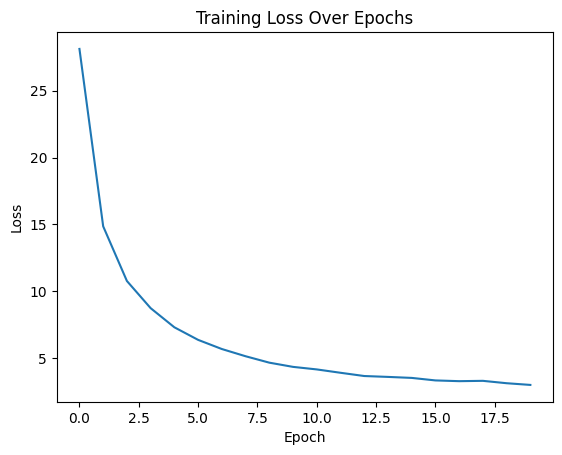

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def train(model, X_train, y_train, X_test, y_test, epochs, batch_size):
    optimizer = tf.optimizers.Adam()  # Optimizer for updating the weights
    epoch_losses = []  # List to store average losses for each epoch

    for epoch in range(epochs):
        losses = []  # List to store losses for each batch within an epoch
        total_loss_this_epoch = 0
        for i in range(0, X_train.shape[0], batch_size):
            with tf.GradientTape() as tape:
                inputs = tf.convert_to_tensor(X_train[i:i + batch_size], dtype=tf.float32)
                labels = tf.convert_to_tensor(y_train[i:i + batch_size], dtype=tf.float32)

                # One-hot encode the labels if needed (uncomment if your problem is multi-class classification)
                # labels = tf.one_hot(labels, depth=6)  # Adjust depth according to your number of classes

                logits = model(inputs)  # Get the model output for the inputs

                # Ensure logits and labels have the same shape
                if logits.shape[-1] == 1:
                    labels = tf.expand_dims(labels, axis=-1)
                else:
                    labels = tf.one_hot(tf.cast(labels, tf.int32), depth=logits.shape[-1])

                # Calculate the data loss using sigmoid cross-entropy
                data_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=labels, logits=logits))
                reg_loss = model.get_l2_loss()  # Regularization loss from the model
                total_loss = data_loss + reg_loss  # Total loss includes both data and regularization loss
                total_loss_this_epoch += total_loss

            # Calculate gradients of total loss with respect to model parameters
            gradients = tape.gradient(total_loss, [var for layer in model.layers for var in [layer['W'], layer['b']]])
            # Apply gradients to update model parameters
            optimizer.apply_gradients(zip(gradients, [var for layer in model.layers for var in [layer['W'], layer['b']]]))

        losses.append(total_loss_this_epoch.numpy())  # Append the total loss of the current epoch to the losses list

        # Logging the average loss every epoch
        print(f"Epoch {epoch}, Loss: {total_loss_this_epoch.numpy()}")  # Print total loss of the epoch
        train_acc = test_model(model, X_train, y_train)
        test_acc = test_model(model, X_test, y_test)
        print("Train_acc = {}, Test_acc = {}".format(round(train_acc, 4), round(test_acc, 4)))

        epoch_losses.append(total_loss_this_epoch.numpy())  # Store the total loss of the epoch

    # Plot the losses after training
    plt.plot(epoch_losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.show()


# Example usage:
# Assuming New_Model is defined and compiled correctly
# Assuming X_train, X_test, y_train, y_test are defined
train(New_Model, X_train, y_train, X_test, y_test, 20, 128)


In [ ]:
len(losses)

480

In [ ]:
# Assume y_encoded is a NumPy array
unique_values = np.unique(y_encoded)
num_unique_values = len(unique_values)

print("Number of unique values:", num_unique_values)
print(unique_values)



Number of unique values: 6
[0 1 2 3 4 5]


In [ ]:
train_acc = test_model(New_Model, X_train, y_train)

In [ ]:
train_acc

0.9848978704910908

In [ ]:
test_acc = test_model(New_Model, X_test, y_test)
test_acc

0.9847892220773576

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
# Standardize the data (zero mean, unit variance)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize the Logistic Regression model
log_reg = LogisticRegression(max_iter=10000)

# Train the model
log_reg.fit(X_train, y_train)

# Make predictions
y_pred_log = log_reg.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_log)
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_log))
print("Classification Report:\n", classification_report(y_test, y_pred_log))

Accuracy: 0.9826162538026945
Confusion Matrix:
 [[ 543    0    0    0    0    1]
 [   0 1425    0   10    0    0]
 [   1    0   43    0    0    0]
 [   4   19    0  200    0    0]
 [   1    1    0    2    7    0]
 [   1    0    0    0    0   43]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       544
           1       0.99      0.99      0.99      1435
           2       1.00      0.98      0.99        44
           3       0.94      0.90      0.92       223
           4       1.00      0.64      0.78        11
           5       0.98      0.98      0.98        44

    accuracy                           0.98      2301
   macro avg       0.98      0.91      0.94      2301
weighted avg       0.98      0.98      0.98      2301



As observed from the output of both the deep learning algorithm and the logistic regression model, we achieved a similar accuracy rate of approximately 0.98 on the test sets. This indicates that both approaches are highly effective for this classification task.